<a href="https://colab.research.google.com/github/nascetti-a/xview2_tests/blob/main/xView2_Geolocation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependecies & Google drive

In [ ]:
!pip install geopandas
!pip install contextily
!pip install -U leafmap
!pip install rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set parameters and import modules


In [2]:
import json
import rasterio
import numpy as np
import glob 
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely import wkt
from leafmap import leafmap



In [15]:
from pathlib import Path

ROOT = Path("/content/drive/MyDrive/XView2_samples")
DISASTER_TYPE = "flooding" #[flooding, hurricane, tsunami, wildfire, earthquake, volcano]
FOLDER = ROOT / DISASTER_TYPE
LABEL_FOLDER = FOLDER / "labels"
IMAGES_FOLDER = FOLDER / "images"
OUTPUT_FOLDER = Path('/content/drive/MyDrive/Xview2/test_coregistration_4326')

if OUTPUT_FOLDER.exists() is False:
  OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

f = open(FOLDER / 'geotransforms.json')
data = json.load(f)

# Coregistration Class 

In [3]:
from matplotlib import pyplot as plt
import cv2

class ImageCoregistration:

    def __init__(self,source_image, target_image, transformation_type='Affine'):
        self.source_image = source_image
        self.target_image = target_image
        self.transformation_type = transformation_type
        self.warp_matrix = None

        # Specify the number of iterations.
        self.number_of_iterations = 1000;

        # Specify the threshold of the increment
        # in the correlation coefficient between two iterations
        self.termination_eps = 1e-10;

    def coregister_images(self):
        # Convert images to grayscale uint8 if they are not already
        if len(self.source_image.shape) == 3:
            source_image_gray = cv2.cvtColor(self.source_image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
        else:
            source_image_gray = self.source_image.astype(np.uint8)

        if len(self.target_image.shape) == 3:
            target_image_gray = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
        else:
            target_image_gray = self.target_image.astype(np.uint8)

        plt.imshow(source_image_gray)
        plt.show()

        plt.imshow(target_image_gray)
        plt.show()

        # Perform image coregistration and get warp matrix
        if self.transformation_type == 'Affine':
            _, warp_matrix = cv2.findTransformECC(target_image_gray, source_image_gray, np.eye(2, 3, dtype=np.float32),
                                                  cv2.MOTION_AFFINE, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10000, 1e-5))
        elif self.transformation_type == 'Homography':
            _, warp_matrix = cv2.findTransformECC(target_image_gray, source_image_gray, np.eye(3, 3, dtype=np.float32),
                                                  cv2.MOTION_HOMOGRAPHY, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10000, 1e-5))
        elif self.transformation_type == 'Motion':
            _, warp_matrix = cv2.findTransformECC(target_image_gray, source_image_gray, np.eye(2, 3, dtype=np.float32),
                                                  cv2.MOTION_TRANSLATION, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10000, 1e-5))
        else:
            raise ValueError("Invalid transformation type. Available options are 'Affine', 'Homography', and 'Motion'.")

        self.warp_matrix = warp_matrix
    
    
    def get_warp_matrix(self):
        if self.warp_matrix is None:
          self.coregister_images()

        return self.warp_matrix

    def get_aligned_image(self): 
        if self.warp_matrix is None:
          self.coregister_images()

        if self.transformation_type == 'Homography':
        # Use warpPerspective for Homography
            aligned_image = cv2.warpPerspective(self.source_image, self.warp_matrix, (self.target_image.shape[1], self.target_image.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else:
        # Use warpAffine for Translation, Euclidean and Affine
            aligned_image = cv2.warpAffine(self.source_image, self.warp_matrix, (self.target_image.shape[1], self.target_image.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

        return aligned_image
  

In [ ]:
# TEST Coregistration Class 

from leafmap import leafmap

bbox = [-79.0572708346348492,33.6030591065453805, -79.0526178504798480,33.6077120907003817]

leafmap.tms_to_geotiff('satellite_zoom18.tif', bbox, zoom=18, source='Satellite')

import cv2

ref = cv2.imread('satellite_zoom18.tif')
img = cv2.imread('/content/drive/MyDrive/XView2_samples/hurricane/images/hurricane-florence_00000000_pre_disaster.tif', cv2.IMREAD_UNCHANGED)


cc = ImageCoregistration(img, ref, transformation_type="Affine")

im2_aligned = cc.get_aligned_image()

print(cc.warp_matrix)

import rasterio

src_im1 = rasterio.open('/content/drive/MyDrive/XView2_samples/hurricane/images/hurricane-florence_00000000_pre_disaster.tif')

with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = src_im1.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    #profile.update(
    #    dtype=rasterio.uint8,
    #    count=1,
    #    compress='lzw')

    with rasterio.open('hurricane-florence_00000000_pre_disaster_affine_class2.tif', 'w', **profile) as dst:
        dst.write(im2_aligned, 1)

# Main loop

/content/drive/MyDrive/XView2_samples/flooding/labels/midwest-flooding_00000002_post_disaster.json
Downloaded image 1/20
Downloaded image 2/20
Downloaded image 3/20
Downloaded image 4/20
Downloaded image 5/20
Downloaded image 6/20
Downloaded image 7/20
Downloaded image 8/20
Downloaded image 9/20
Downloaded image 10/20
Downloaded image 11/20
Downloaded image 12/20
Downloaded image 13/20
Downloaded image 14/20
Downloaded image 15/20
Downloaded image 16/20
Downloaded image 17/20
Downloaded image 18/20
Downloaded image 19/20
Downloaded image 20/20
Saving GeoTIFF. Please wait...
Image saved to /content/drive/MyDrive/Xview2/test_coregistration_4326/midwest-flooding_00000002_post_disaster_temp_basemap.tif


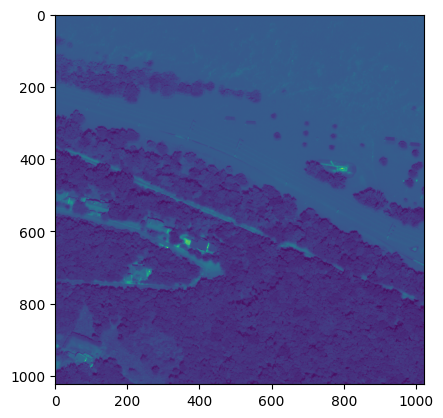

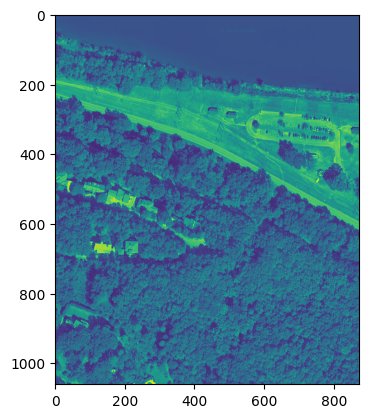

1.1047064533696533 1.0237575485664379 -0.02109428723947487 -66.55194368458005 0.024401824027964557 1.0950392295558495
4.566050436065726e-06 0.0 -92.3476694069814 0.0 -4.566050436065726e-06 34.78818504954187
/content/drive/MyDrive/XView2_samples/flooding/labels/midwest-flooding_00000001_post_disaster.json
Downloaded image 1/25
Downloaded image 2/25
Downloaded image 3/25
Downloaded image 4/25
Downloaded image 5/25
Downloaded image 6/25
Downloaded image 7/25
Downloaded image 8/25
Downloaded image 9/25
Downloaded image 10/25
Downloaded image 11/25
Downloaded image 12/25
Downloaded image 13/25
Downloaded image 14/25
Downloaded image 15/25
Downloaded image 16/25
Downloaded image 17/25
Downloaded image 18/25
Downloaded image 19/25
Downloaded image 20/25
Downloaded image 21/25
Downloaded image 22/25
Downloaded image 23/25
Downloaded image 24/25
Downloaded image 25/25
Saving GeoTIFF. Please wait...
Image saved to /content/drive/MyDrive/Xview2/test_coregistration_4326/midwest-flooding_00000001_p

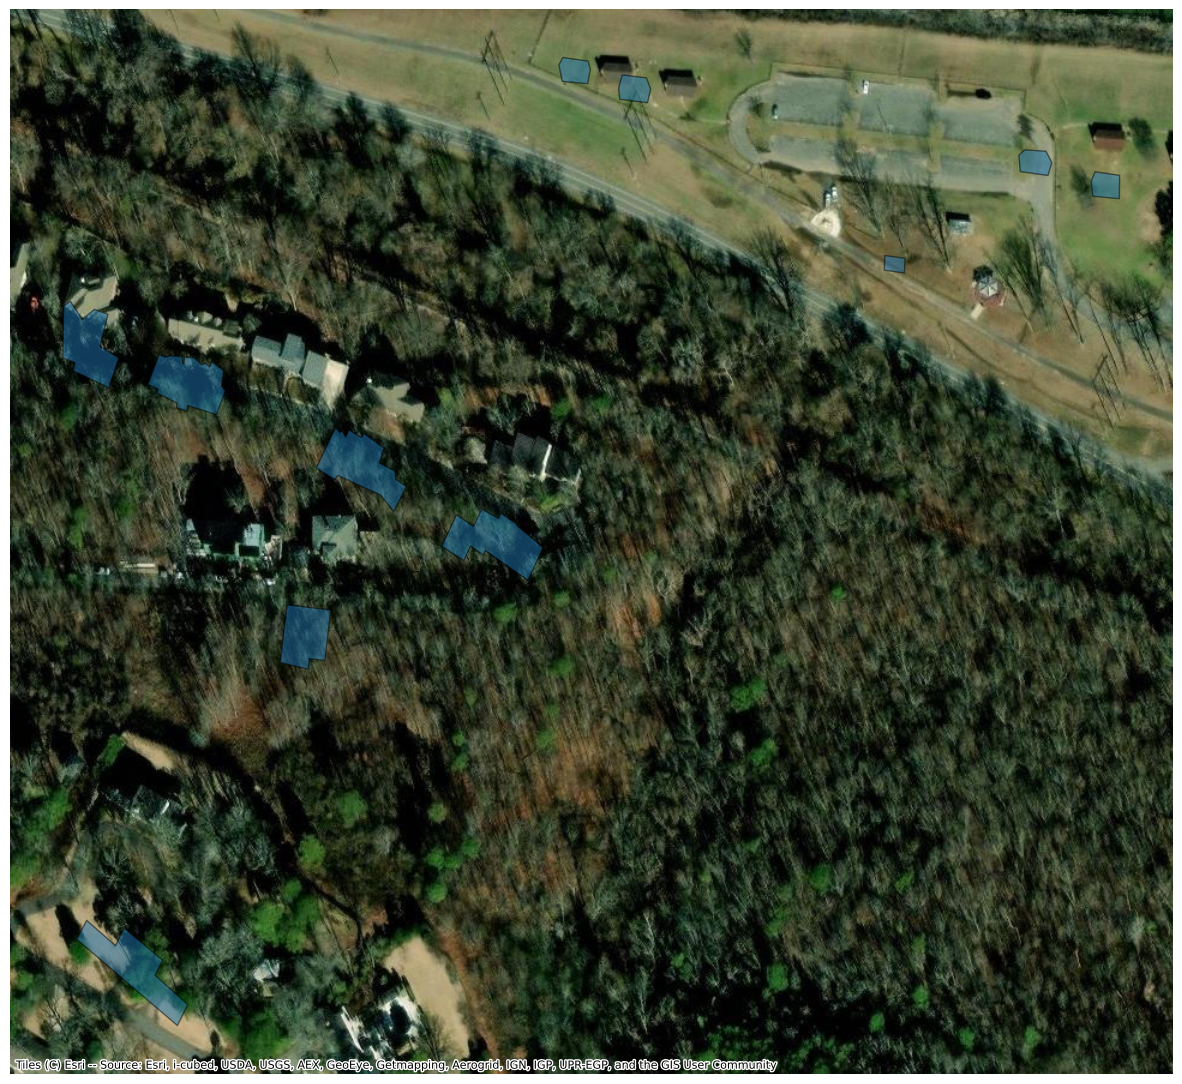

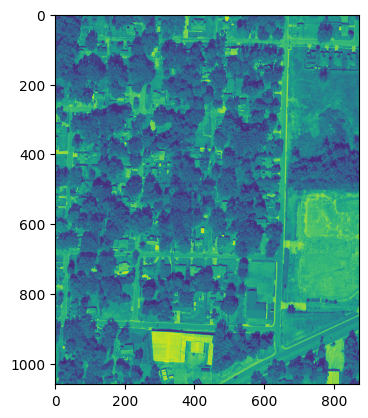

14.773789922158528 0.9184316054190598 -0.007474850235380634 -33.039685520119235 0.002389709514281582 0.9709011108061664
4.565891579459006e-06 0.0 -92.36797059628226 0.0 -4.565891579459006e-06 34.71725447446686


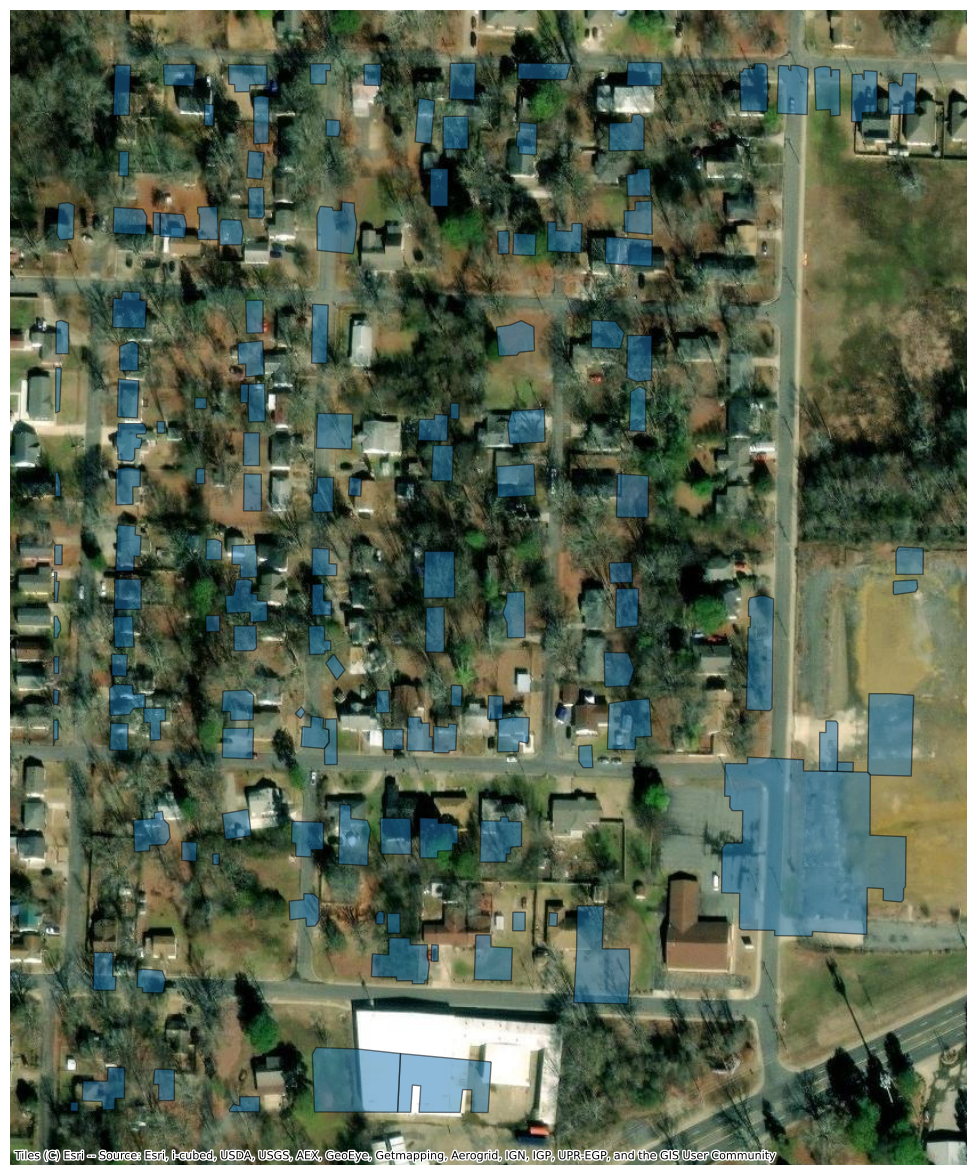

In [16]:
for file in glob.glob(LABEL_FOLDER.as_posix() + '/*_post_disaster.json'):  
  print(file)

  with open(file, 'rb') as labels_json_file:
    labels_json = json.load(labels_json_file)
  
  coords = labels_json['features']['xy']
  wkt_polygons = []

  for coord in coords:
      if 'subtype' in coord['properties']:
          damage = coord['properties']['subtype']
      else:
          damage = 'no-damage'
          
      wkt_polygons.append((damage, coord['wkt']))
    
  polygons = []

  for damage, swkt in wkt_polygons:
      polygons.append((damage, wkt.loads(swkt)))

  file = Path(file)

  ldb = pd.DataFrame(data=polygons, columns=['damage', 'geometry'])

  # *** Coregister post image respet to basemap *** 

  post_img = rasterio.open(IMAGES_FOLDER /(file.stem +'.tif'))
  left, bottom, right, top = post_img.bounds
  bbox = [left, bottom, right, top ]

  # Save base maps as geotif
  leafmap.tms_to_geotiff((OUTPUT_FOLDER / (file.stem +'_temp_basemap.tif')).as_posix(), bbox, zoom=18, source='Satellite')

  ref = cv2.imread((OUTPUT_FOLDER / (file.stem +'_temp_basemap.tif')).as_posix())
  
  post_img_bands = np.float32(np.transpose(post_img.read([1,2,3]), (1,2,0)))

  cc = ImageCoregistration(post_img_bands, ref, transformation_type="Affine")

  #print(cc.get_warp_matrix())

  try: 
    post_img_aligned = cc.get_aligned_image()
  
  except:
    print("Error 01: no possible to align the images")
    break 
  
  with rasterio.Env():
    profile = post_img.profile

    with rasterio.open(OUTPUT_FOLDER / (file.stem +'_corrected.tif'), 'w', **profile) as dst:
        dst.write(np.transpose(post_img_aligned, (2,0,1)))

  gdf = gpd.GeoDataFrame(ldb, geometry=ldb.geometry , crs="EPSG:4326")

  #print(gdf.head())

  # Apply coregistration warp matrix to labels
  a, b, xoff, c, d, yoff = cc.get_warp_matrix().flatten()
  
  matrix_1 = np.array([[a, b, xoff],[c, d, yoff],[0, 0, 1]])
  inverse_transform = np.linalg.inv(matrix_1)

  a, b, xoff, c, d, yoff = inverse_transform[0:2].flatten()
  print(xoff, a, b, yoff, c, d )
  # -23.945793 1.0882161 0.020787742 -5.168588 -0.016148215 1.0812116

  gdf['geometry'] = gdf.affine_transform([a,b,c,d,xoff,yoff])
  #gdf.to_file((file.stem +'_temp.geojson'), driver="GeoJSON") 

  # Apply geotrasformation to labels
  #base_map = rasterio.open(OUTPUT_FOLDER / (file.stem + '_temp_basemap.tif'))
  #a1, b1, xoff1, c1, d1, yoff1 = np.array(base_map.transform)[0:6]
  
  xoff1, a1, b1, yoff1, c1, d1 = data[file.stem + ".png"][0]
  
  print(a1, b1, xoff1, c1, d1, yoff1 )

  gdf['geometry'] = gdf.affine_transform([a1,b1,c1,d1,xoff1,yoff1])


  #matrix_2 = np.array([[a1, b1, xoff1],[c1, d1, yoff1],[0, 0, 1]])
  #print(matrix_2)

  #gdf2 = gpd.read_file((file.stem +'_temp.geojson'))

  #print(gdf.head())

  #matrix_1 = np.array([[1, 0, xoff*a1],[0, 1, yoff*d1],[0, 0, 1]])

  #combine_transf = matrix_1 @ matrix_2

  #print(combine_transf)

  #a, b, xoff, c, d, yoff = combine_transf[0:2].flatten()

  gdf.crs = 4326  # this line
  map_df = gdf.to_crs(epsg=3857)

  ax = map_df.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
  ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
  ax.set_axis_off()

  gdf.to_file(OUTPUT_FOLDER / (file.stem +'_test_inverse.geojson'), driver="GeoJSON")  




In [14]:
data.keys()

dict_keys(['santa-rosa-wildfire_00000002_pre_disaster.png', 'santa-rosa-wildfire_00000002_post_disaster.png', 'santa-rosa-wildfire_00000003_pre_disaster.png', 'santa-rosa-wildfire_00000003_post_disaster.png'])

In [13]:
!rm *.geojson

# Random tests

[[ 1.0866098e+00  2.0140391e-02 -2.2562887e+01]
 [-1.8923948e-02  1.0812581e+00 -5.1562085e+00]]

 -23.945793 1.0882161 0.020787742 -5.168588 -0.016148215 1.0812116



In [120]:
!rm *.tif

In [113]:
I = 650
J = 792

In [114]:
 1.0882161 * I + 0.020787742 * J -23.945793

699.858563664

In [115]:
-0.016148215 * I + 1.0812116 *J -5.168588

840.65465945

## Try x-view-2 feature based coregistration

In [4]:
!git clone https://github.com/ethanweber/xview2.git

Cloning into 'xview2'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 792 (delta 69), reused 77 (delta 30), pack-reused 664
Receiving objects: 100% (792/792), 98.25 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (316/316), done.


In [1]:
import os
os.chdir('/content/xview2/cnn-registration-publish/src/')

In [5]:
from utils.utils import *
#import Registration
import cv2

In [ ]:
from __future__ import print_function
import time
import gc

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from VGG16 import VGG16mo
from utils.utils import *
import cv2
from lap import lapjv
from utils.shape_context import ShapeContext
import matplotlib.pyplot as plt

class CNN(object):
    def __init__(self):
        self.height = 224
        self.width = 224
        self.shape = np.array([224.0, 224.0])

        self.sift_weight = 2.0
        self.cnn_weight = 1.0

        self.max_itr = 200

        self.tolerance = 1e-2
        self.freq = 5 # k in the paper
        self.epsilon = 0.5
        self.omega = 0.5
        self.beta = 2.0
        self.lambd = 0.5

        self.cnnph = tf.placeholder("float", [2, 224, 224, 3])
        self.vgg = VGG16mo()
        self.vgg.build(self.cnnph)
        self.SC = ShapeContext()

    def register(self, IX, IY):

        # set parameters
        tolerance = self.tolerance
        freq = self.freq
        epsilon = self.epsilon
        omega = self.omega
        beta = self.beta
        lambd = self.lambd

        # resize image
        Xscale = 1.0 * np.array(IX.shape[:2]) / self.shape
        Yscale = 1.0 * np.array(IY.shape[:2]) / self.shape
        IX = cv2.resize(IX, (self.height, self.width))
        IY = cv2.resize(IY, (self.height, self.width))

        # CNN feature
        # propagate the images through VGG16
        IX = np.expand_dims(IX, axis=0)
        IY = np.expand_dims(IY, axis=0)
        cnn_input = np.concatenate((IX, IY), axis=0)
        with tf.Session() as sess:
            feed_dict = {self.cnnph: cnn_input}
            D1, D2, D3 = sess.run([
                self.vgg.pool3, self.vgg.pool4, self.vgg.pool5_1
            ], feed_dict=feed_dict)

        # flatten
        DX1, DY1 = np.reshape(D1[0], [-1, 256]), np.reshape(D1[1], [-1, 256])
        DX2, DY2 = np.reshape(D2[0], [-1, 512]), np.reshape(D2[1], [-1, 512])
        DX3, DY3 = np.reshape(D3[0], [-1, 512]), np.reshape(D3[1], [-1, 512])

        # normalization
        DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)
        DX2, DY2 = DX2 / np.std(DX2), DY2 / np.std(DY2)
        DX3, DY3 = DX3 / np.std(DX3), DY3 / np.std(DY3)

        del D1, D2, D3

        # compute feature space distance
        PD1 = pairwise_distance(DX1, DY1)
        PD2 = pd_expand(pairwise_distance(DX2, DY2), 2)
        PD3 = pd_expand(pairwise_distance(DX3, DY3), 4)
        PD = 1.414 * PD1 + PD2 + PD3

        del DX1, DY1, DX2, DY2, DX3, DY3, PD1, PD2, PD3

        seq = np.array([[i, j] for i in range(28) for j in range(28)], dtype='int32')

        X = np.array(seq, dtype='float32') * 8.0 + 4.0
        Y = np.array(seq, dtype='float32') * 8.0 + 4.0

        # normalize
        X = (X - 112.0) / 224.0
        Y = (Y - 112.0) / 224.0

        # prematch and select points
        C_all, quality = match(PD)
        tau_max = np.max(quality)
        while np.where(quality >= tau_max)[0].shape[0] <= 128: tau_max -= 0.01

        C = C_all[np.where(quality >= tau_max)]
        cnt = C.shape[0]

        # select prematched feature points
        X, Y = X[C[:, 1]], Y[C[:, 0]]
        PD = PD[np.repeat(np.reshape(C[:, 1], [cnt, 1]), cnt, axis=1),
                np.repeat(np.reshape(C[:, 0], [1, cnt]), cnt, axis=0)]

        N = X.shape[0]
        M = X.shape[0]
        assert M == N

        # precalculation of feature match
        C_all, quality = match(PD)

        # compute \hat{\theta} and \delta
        tau_min = np.min(quality)
        tau_max = np.max(quality)
        while np.where(quality >= tau_max)[0].shape[0] <= 0.5 * cnt: tau_max -= 0.01
        tau = tau_max
        delta = (tau_max - tau_min) / 10.0

        SCX = self.SC.compute(X)

        # initialization
        Z = Y.copy()
        GRB = gaussian_radial_basis(Y, beta)
        A = np.zeros([M, 2])
        sigma2 = init_sigma2(X, Y)

        Pr = None

        Q = 0
        dQ = float('Inf')
        itr = 1

        # registration process
        while itr < self.max_itr and abs(dQ) > tolerance and sigma2 > 1e-4:
            Z_old = Z.copy()
            Q_old = Q

            # for every k iterations
            if (itr - 1) % freq == 0:
                # compute C^{conv}_{\theta}
                C = C_all[np.where(quality >= tau)]
                Lt = PD[C[:, 0], C[:, 1]]
                maxLt = np.max(Lt)
                if maxLt > 0: Lt = Lt / maxLt
                L = np.ones([M, N])
                L[C[:, 0], C[:, 1]] = Lt

                # compute C^{geo}_{\theta}
                SCZ = self.SC.compute(Z)
                SC_cost = self.SC.cost(SCZ, SCX)

                # compute C
                L = L * SC_cost

                # linear assignment
                C = lapjv(L)[1]

                # prior probability matrix
                Pr = np.ones_like(PD) * (1.0 - epsilon) / N
                Pr[np.arange(C.shape[0]), C] = 1.0
                Pr = Pr / np.sum(Pr, axis=0)

                tau = tau - delta
                if tau < tau_min: tau = tau_min

            # compute minimization
            Po, P1, Np, tmp, Q = compute(X, Y, Z_old, Pr, sigma2, omega)
            Q = Q + lambd / 2 * np.trace(np.dot(np.dot(A.transpose(), GRB), A))

            # update variables
            dP = np.diag(P1)
            t1 = np.dot(dP, GRB) + lambd * sigma2 * np.eye(M)
            t2 = np.dot(Po, X) - np.dot(dP, Y)
            A = np.dot(np.linalg.inv(t1), t2)
            sigma2 = tmp / (2.0 * Np)
            omega = 1 - (Np / N)
            if omega > 0.99: omega = 0.99
            if omega < 0.01: omega = 0.01
            Z = Y + np.dot(GRB, A)
            lambd = lambd * 0.95
            if lambd < 0.1: lambd = 0.1

            dQ = Q - Q_old
            itr = itr + 1

        print('finish: itr %d, Q %d, tau %d' % (itr, Q, tau))
        return ((X*224.0)+112.0)*Xscale, ((Y*224.0)+112.0)*Yscale, ((Z*224.0)+112.0)*Xscale

In [ ]:
# load images
IX = cv2.imread('/content/satellite_high.tif')
IY = cv2.imread('/content/satellite_high.tif')

#initialize
reg = CNN()

In [ ]:
from VGG16 import VGG16mo

aaa = VGG16mo(vgg16_npy_path = '/content/xview2/cnn-registration-publish/src/VGG16.py')